## Colab preamble

If this notebook is running on Google CoLab, we need to set up the required dependencies. The cell below checks if we're running on colab and tries to install the needed dependencies

In [1]:
# This installs the required python packages if we are running on colab
try:
    import google.colab
    # Install required packages.
    import os
    import torch
    os.environ['TORCH'] = torch.__version__
    print(torch.__version__)

    !pip install lightning
    !pip install transformers datasets evaluate
except:
    pass

# Transformers

In this workshop we will go trough how to implement a Transformer using the PyTorch building blocks, and then look at how we can use the HuggingFace library to easily access a huge library of prebuilt models.

## What is a Transformer

While the original Transformer architecture was an evolution of Attentive Recurrent Neural Networks used for sequence-to-sequence (e.g. machine translation), the architecture is not actually a sequence model. A better way to think about Transformers are as _set_ models, neural networks for learning to do things with sets of vectors.

![Illustration of Transformer permutation invariance](images/permutation_invariance_initialize_memory_small.png)

## How a Transformer learns on sets

At the heart of the Transformer is the self-attention mechanism. This essentially learns how to perform a weighted sum of all set inputs. Below is the equation for how we aggregate a new feature vector $z_i$ for the input ${v_1, \dots, v_n}$.

$\begin{equation}\mathbf{z}_i = \sum_{j =1}^{N} a_{ij}\mathbf{v}_j\end{equation}$

The output of the Transformer block is then this vector passed through a 2-layer neural network (in practice, we will produce $H$ different such vectors, one for each of $H$ number of _attention heads_ but we gloss over this here, imagine we have a _single head_ Transformer).

$\begin{equation} \tag{2} \mathbf{h}_i = W_2 \sigma(W_1 \mathbf{z_i} + \beta_1) + \beta_2 \end{equation}$

The focus of any coverage of Transformers is often the $a_{ij}$ in equation $(1)$ above, this coefficient is the attention score, a value between $0$ and $1$ which essentially _selects_ which value vectors $\mathbf{v}_j$ to include in the aggregation. In the original Transformer paper and most derivations, this value is produced softmaxed _scaled dot-product attention_, the inner product $<\mathbf{q}_i, \mathbf{k}_j>$ for vectors which relate to the corresponding $\mathbf{v}_i$ and $\mathbf{v}_j$. In this workshop, we won't go into detail on implementing this operation and instead focus on how we can use existing implementations as building blocks to implement a full Transformer.

If you've previously seen Graph Neural Networks, you can see that there's a close similarity to the SUM aggregation operation of graph convolutions:

$\begin{equation}\mathbf{z}_i = \sum_{j \in \mathcal{N}(i)} a_{ij}\mathbf{v}_j\end{equation}$

Here $\mathcal{N}(i)$ is the neighbourhood of node $i$. Another way to think of this is to write it out as using the elements of the adjacency matrix $A$:

$\begin{equation}\mathbf{z}_i = \sum_{j =1}^{N} A_{ij}\mathbf{v}_j\end{equation}$

In a GNN, the matrix A is given by the graph structure, so is fixed and decided beforehand. We can think of what a Transforma is doing as actually _generalizing_ a GNN by allowing this entry $A_{ij}$ to be _computed_ by some function. This can be seen as us _computing_ the adjacency matrix:

$$
\begin{bmatrix}
f(v_1, v_1) & \dots & f(v_1, v_n)\\
\vdots & \ddots & \vdots \\
f(v_n, v_1) & \dots & f(v_n, v_n)
\end{bmatrix}
$$

This has proven to be a very powerful method of learning relationships between input entities, but it has a cost of having a complexity (both space and time) of $O(N^2)$. In the case with GNNs, since we know beforehand what items interact (the neighbourhoods of the graph) we could use _sparse_ operations which avoided the quadratic complexity as long as the graph was realatively sparse (the node degree was much lower than the number of nodes).

This is one of the reasons for why Transformers often limit the size of the inputs. The popular BERT model only allowed for 512 inputs, while current (as of August 2023) LLM are often lmited around 4192 inputs.

## First order of business - how to represent inputs

The Transformer expects a set of vectors as input. It's agnostic to exactly what those represent. When applied to language, these vectors are _token embeddings_, where the strings are represented by chunked up substrings according to certain rules - tokenizations. For models since at least BERT, these tokenizations build on statistical properties of the basic characters. Common subsequences are grouped together into new tokens.

For other kinds of data, we need to decide on how to create these tokens.

As mentioned above, the Transformer is _permutation invariant_, it has no notion of an _order_ between the input vectors. The original line of works solved this by adding information about positions to the input vectors, so called positional encodings.

![Illustration of Transformer permutation invariance](images/permutation_invariance_initialize_memory_small.png)

## Early Transformers for images - ImageGPT

The Generative Pre-Trained Transformer (GPT) was an early work on Transformer _foundation models_ from OpenAI. They trained a decoder-only Transformer in a next step prediction language modelling task and showed promising results on transfer learning. This was overshadowed at the time by the BERT style encoder-only model which used a pseudo language modelling task, called Masked Language Modelling which is similar to a denoising auto encoder. Lately there's been a comeback of GPT-style Transformers. The potential of general language understanding using generative language models has made it the most used method currently.

One of the earlier attempts of using Transformers for computer vision was the [ImageGPT](https://openai.com/research/image-gpt), also by OpenAI. The idea was simple, to take an image and treat _each pixel_ as a token and simply _flatten_ the image into a sequence.

![Example from the ImageGPT blog post](images/imagegpt.png)


### ImageGPT

In the paper, the authors made as little modification as possible to the neural network architecture. This meant that they sticked to an architecture with categorical inputs and outputs, as well as the _vocabulary size_ of 50000 tokens. We will reimplement this archicture below using PyTorch. As an example dataset we will use the Oxford III pets dataset. This is significantly smaller than the dataset used in the original ImageGPT article, but it will serve as an illustration.

In [2]:
import torchvision
dataset = torchvision.datasets.OxfordIIITPet('../datasets/oxfordiiipet', download=True)

### The issue of complexity
The Transformer model we will use is of quadratic computational complexity with regards to the size of the input. If we take an image of size 224x224 pixels, it would results in a total input size of 50 176, _far_ more than what contemporary Transformers are trained on. If we further were to treat each color channel as its own token this would ballon to a size of more than 15000, which is just not feasible for current hardware. The solution to this is simply to scale down the images to a smaller size. We will here pick the smalles of the original paper, 32x32. This leaves us with an input of "only" 1024 pixels. We will also treat each RGB triplet as a token instead of each channel individually by creating a fixed vocabulary using _vector quantization_.

#### The vocabulary - Vector Quantization

The ImageGPT follows the GPT-2 architecture closely, in particular using discrete inputs and outputs, so a question is how to _discretize_ our images to have a fixed vocabulary?
Each pixel can be seen as a 3-dimensional vector where the elements are in the range $[0,1]$ (we think of this as continuous even though it might be based on 24bit color depth). To convert the pixels into a fixed vocabulary we will use _vector quantization_, a classical and very useful tool for compression. In the paper they choose a vocabulary size of 512 (9bits) which is what we will do as well. We will try to find 512 _prototypical_ pixels: fixed vectors which we can substitute the actual pixels with, without loosing too much information. There are many ways we could try to find these prototype vectors, but the method in the ImageGPT paper was to use _k-means_ clustering which is what we will do as well. To keep compute time relatively low, we will do this on scaled down versions of the images.

In [3]:
import torch
import torchvision
import torchvision.transforms.v2 as tvtransforms
#import torchvision.transforms as tvtransforms
transforms = tvtransforms.Compose([
    tvtransforms.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    tvtransforms.ToDtype(torch.uint8),  # optional, most input are already uint8 at this point
    tvtransforms.Resize((32,32), antialias=False)
])

In [4]:
resized_dataset = torchvision.datasets.OxfordIIITPet('../datasets/oxfordiiipet', download=True, transforms=transforms)

In [5]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
images = []
labels = []
for image, label in tqdm(resized_dataset, desc='reading images'):
    images.append(image.reshape(3,-1)) # Flatten the images
    labels.append(label)  # Take the opportunity to summarize the labels while we're at it 
pixels = torch.cat(images, dim=-1)  # Put it all in a single tensor

reading images:   0%|          | 0/3680 [00:00<?, ?it/s]

We will use the k-means clustering algorithm from scikit-learn. The MiniBatchKMeans is often best when the number of points is high (in our case it's over 3 million vectors).

In [6]:
from sklearn.cluster import MiniBatchKMeans
vocab_size = 512
n_cores=8
codebook = MiniBatchKMeans(n_clusters=vocab_size, random_state=1729, batch_size=256*n_cores, n_init="auto")
codebook.fit(pixels.transpose(1,0).numpy())


MiniBatchKMeans(batch_size=2048, n_clusters=512, random_state=1729)

This leaves us with a clustering where we can use `codebook.predict()` to perform the quantization.

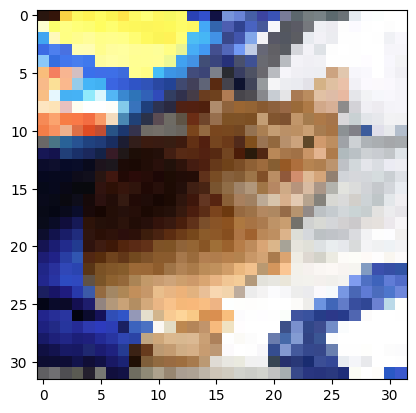

In [7]:
image, label = resized_dataset[0]
plt.imshow(image.permute(1,2,0).numpy())

In [8]:
encoded_image_flat = codebook.predict(image.permute(1,2,0).reshape(-1,3).numpy())
encoded_image_flat

array([450, 398, 289, ...,  77, 381,  37], dtype=int32)

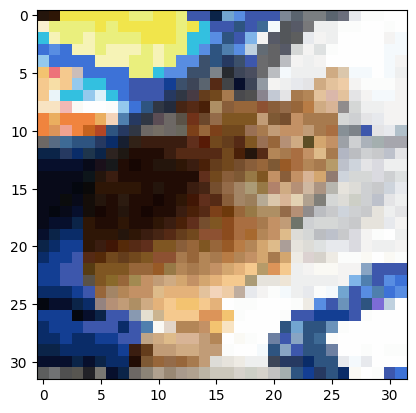

In [9]:
import numpy as np
# The encoded image are the indices of the code vectors in the cluster centers of our kmean clustering
decoded_image_flat = codebook.cluster_centers_[encoded_image_flat]
decoded_image = decoded_image_flat.reshape((32,32,3)).astype(dtype=np.uint8)
plt.imshow(decoded_image)

In [10]:
from torchvision.transforms.v2 import Transform

class CodeBookTransform(Transform):
    def __init__(self, codebook):
        super().__init__()
        self.codebook = codebook

    def transform(self, inpt, params):
        encoded_image_flat = codebook.predict(inpt.permute(1,2,0).reshape(-1,3).numpy())
        return torch.LongTensor(encoded_image_flat)

class InverseCodeBookTransform(Transform):
    def __init__(self, codebook):
        super().__init__()
        self.codebook = codebook

    def transform(self, inpt, params):
        decoded_image_flat = self.codebook.cluster_centers_[inpt]
        decoded_image = decoded_image_flat.reshape((32,32,3)).astype(dtype=np.uint8)
        return torch.LongTensor(decoded_image).permute(2,0,1)

In [11]:
from sklearn.cluster import MiniBatchKMeans
vocab_size = 512
n_cores=8
codebook = MiniBatchKMeans(n_clusters=vocab_size, random_state=1729, batch_size=256*n_cores, n_init="auto")
codebook.fit(pixels.transpose(1,0).numpy())

vq_transforms = tvtransforms.Compose([
    tvtransforms.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    tvtransforms.ToDtype(torch.uint8),  # optional, most input are already uint8 at this point
    tvtransforms.AutoAugment(), # Applies the IMAGENET auto augmentation strategy
    tvtransforms.Resize((32,32), antialias=False),
    CodeBookTransform(codebook),
    #InverseCodeBookTransform(codebook)
])

In [12]:
vq_dataset = torchvision.datasets.OxfordIIITPet('../datasets/oxfordiiipet', download=True, transforms=vq_transforms)

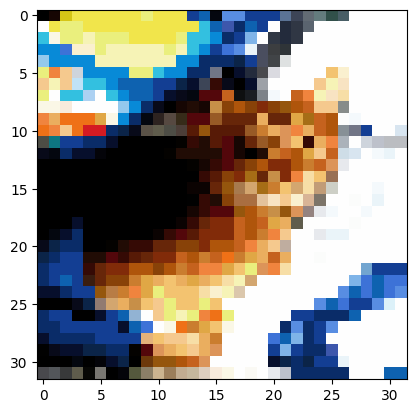

In [13]:
inv_codebook = InverseCodeBookTransform(codebook)

image, label = vq_dataset[0]
decoded_image = inv_codebook(image)
plt.imshow(decoded_image.permute(1,2,0).numpy())

We now have a dataset ready to be used to train our model. We will create a "decode" only style Transformer. This model uses a _causal mask_ so that later computations and inputs can not be used to compute earlier.

In [14]:
import os
from dataclasses import dataclass
import math
from typing import Optional

import torch
from torch import optim, nn, utils, Tensor
import lightning.pytorch as pl

@dataclass
class ImageGPTConfig:
    d_model: int
    n_heads: int
    n_layers: int
    n_embeddings: int
    

class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerDecoderLayer(nn.TransformerDecoderLayer):
    def forward(
        self,
        tgt: Tensor,
        memory: Tensor,
        tgt_mask: Optional[Tensor] = None,
        memory_mask: Optional[Tensor] = None,
        tgt_key_padding_mask: Optional[Tensor] = None,
        memory_key_padding_mask: Optional[Tensor] = None,
        tgt_is_causal: bool = True, # Flag the target as being causal
        memory_is_causal: bool = False,
    ) -> Tensor:
        x = tgt
        if self.norm_first:
            x = x + self._sa_block(self.norm1(x), tgt_mask, tgt_key_padding_mask, tgt_is_causal)
#            x = x + self._mha_block(self.norm2(x), memory, memory_mask, memory_key_padding_mask, memory_is_causal)
            x = x + self._ff_block(self.norm3(x))
        else:
            x = self.norm1(x + self._sa_block(x, tgt_mask, tgt_key_padding_mask, tgt_is_causal))
#            x = self.norm2(x + self._mha_block(x, memory, memory_mask, memory_key_padding_mask, memory_is_causal))
            x = self.norm3(x + self._ff_block(x))
        return x


# define the LightningModule
class LightningImageGPT(pl.LightningModule):
    def __init__(self, config: ImageGPTConfig):
        super().__init__()
        decoder_layer = TransformerDecoderLayer(d_model=config.d_model, nhead=config.n_heads, batch_first=True)
        self.token_embedding_layer = nn.Embedding(config.n_embeddings, config.d_model)
        self.positonal_embedding_layer = PositionalEncoding(config.d_model)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=config.n_layers)
        self.output_projection = nn.Linear(config.d_model, config.n_embeddings)
    
    def loss_on_batch(self, batch):
        x, y = batch  # We'll ignore y, it's the label from the dataset
        x_input = x[:,:-1]  # As inputs we take all "tokens" except the last
        x_output = x[:,1:]  #As targets we take all "tokens" shifted one step to the left
        embedded_tokens = self.token_embedding_layer(x_input)
        positional_embedded_tokens = self.positonal_embedding_layer(embedded_tokens)
        transformer_representations = self.transformer_decoder(positional_embedded_tokens, memory=None)
        output_predictions = self.output_projection(transformer_representations)

        # The loss function wants the classes axis to be the second one, so we permute the predictions so that the sequence
        # dimension is last
        loss = nn.functional.cross_entropy(output_predictions.permute(0,2,1), x_output)

        return loss
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        loss = self.loss_on_batch(batch)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.loss_on_batch(batch)
        # Logging to TensorBoard (if installed) by default
        self.log("dev_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss = self.loss_on_batch(batch)
        # Logging to TensorBoard (if installed) by default
        self.log("test_loss", loss)
        return loss
        
    @torch.no_grad()
    def generate(self, start_sequence, target_length, temperature=1., top_k=None, do_sample=True):
        # Runs a generation forwards for the batch. We iteratively sample new tokens and feed the old ones back
        # Taken from A. Karpathys minGPT: https://github.com/karpathy/minGPT
        self.eval()

        current_sequence = start_sequence
        while len(current_sequence) < target_length:
            # expand the batch *beam_size* times
            embedded_tokens = self.token_embedding_layer(current_sequence.unsqueeze(0))
            positional_embedded_tokens = self.positonal_embedding_layer(embedded_tokens)
            transformer_representations = self.transformer_decoder(positional_embedded_tokens, memory=None)
            output_predictions = self.output_projection(transformer_representations.squeeze()[-1])
            logits = output_predictions/temperature
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')
            probabilities = nn.functional.softmax(logits, dim=-1)
            # either sample from the distribution or take the most likely element
            if do_sample:
                idx_next = torch.multinomial(probabilities, num_samples=1)
            else:
                _, idx_next = torch.topk(probabilities, k=1, dim=-1)
            # append sampled index to the running sequence and continue
            current_sequence = torch.cat((current_sequence, idx_next), dim=-1)
        return current_sequence

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=3e-4)
        return optimizer


In [15]:
config = ImageGPTConfig(d_model=256, n_heads=8, n_layers=4, n_embeddings=512)
model = LightningImageGPT(config)

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
labels = np.array(labels)
#unique_labels, inverse, counts = np.unique(labels, return_inverse=True, return_counts=True)  # just check to make sure there are enough labels to stratify the sample
indices = np.arange(len(labels))
train_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=1729, shuffle=True, stratify=labels)
train_labels = labels[train_indices]
train_indices, dev_indices = train_test_split(train_indices, test_size=0.1, random_state=1729, shuffle=True, stratify=train_labels)

In [17]:
from torch.utils.data import Subset

training_dataset = Subset(vq_dataset, train_indices)
dev_dataset = Subset(vq_dataset, dev_indices)
test_dataset = Subset(vq_dataset, test_indices)

In [18]:
from torch.utils.data import DataLoader
training_dataloader = DataLoader(training_dataset, batch_size=2)

In [19]:
batch = next(iter(training_dataloader))

In [20]:
batch[0].shape

torch.Size([2, 1024])

In [21]:
model.training_step(batch, 1)

/home/erik/src/aida-transformers-workshop-code/.venv/lib/python3.10/site-packages/lightning/pytorch/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(6.4064, grad_fn=<NllLoss2DBackward0>)

In [32]:
from pathlib import Path

from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.lr_monitor import LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

CHECKPOINT_PATH = Path('../models')

trainer = Trainer(default_root_dir = CHECKPOINT_PATH,  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        devices=1,
        precision=16,
        # How many epochs to train for if no patience is set
        max_epochs=10,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="min", monitor="dev_loss"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

/home/erik/src/aida-transformers-workshop-code/.venv/lib/python3.10/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [23]:
%reload_ext tensorboard
%tensorboard --logdir=../models/lightning_logs/

In [26]:
from torch.utils.data import DataLoader
batch_size = 8
num_workers = 0
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [33]:
trainer.fit(model, training_dataloader, dev_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                      | Type               | Params | Mode
------------------------------------------------------------------------
0 | token_embedding_layer     | Embedding          | 131 K  | eval
1 | positonal_embedding_layer | PositionalEncoding | 0      | eval
2 | transformer_decoder       | TransformerDecoder | 6.3 M  | eval
3 | output_projection         | Linear             | 131 K  | eval
------------------------------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.311    Total estimated model params size (MB)
0         Modules in train mode
62        Modules in eval mode
/home/erik/src/aida-transformers-workshop-code/.venv/lib/python3.10/site-packages/lightning/pytorch/loggers/tensorboard.py:191: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/erik/src/aida-transformers-workshop-code/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/erik/src/aida-transformers-workshop-code/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [35]:
test_image, label = test_dataset[0]
half_image = torch.tensor(test_image[:32*16])

/tmp/ipykernel_26446/3702455540.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  half_image = torch.tensor(test_image[:32*16])


In [36]:
model.to('cuda')
generated = model.generate(half_image.to('cuda'), 32*32)

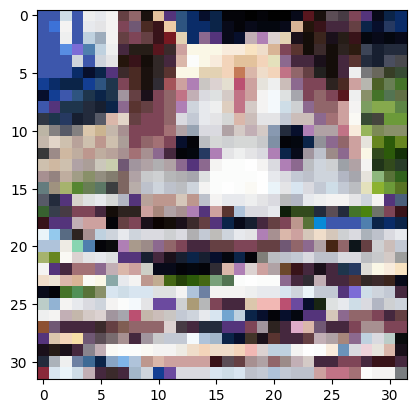

In [37]:
generated_image = inv_codebook(generated.cpu())
plt.imshow(generated_image.permute(1,2,0).numpy())

# Vision Transformers

We saw in the previous example that the quadratic complexity of Transformers forced us to resize the images drastically. While the ImageGPT paper showed that pre-training GPT-style transformers on the images of pixels was promising, it wasn't really practically useful to work with 32x32 images. During the same time as ImageGPT, another application of Transformers to computers gained a lot of attention: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929) from Google Research. While they also aimed to stay close to the original Transformer architecture, they made some changes to how the image was transformed to input. 

Instead of thinking of every pixel as a token, they sliced the image into patches. This makes the actual input size to the Transformer much more manageble. They also didn't force themselves into thinking about the patches as having to be from som fixed vocabulary. Instead they apply a linear transformation to the pixel values of the patches to project them to the correct dimensionality for the transformer. For pretraining, they use the more common supervised pretraining on  ILSVRC-2012 ImageNet, ImageNet-21k and JFT

![Illustration from the Vision Transformer paper](images/vision_transformer.png)

In [59]:
from typing import Any, Dict

import torch
import torchvision
import torchvision.transforms.v2 as tvtransforms
from torchvision.transforms.v2 import Transform

PATCH_SIZE = 16
N_PATCHES = 14
HEIGHT = N_PATCHES*PATCH_SIZE # 224
WIDTH = N_PATCHES*PATCH_SIZE  # 224

class Patchifier(Transform):
    def __init__(self, n_patches, patch_size):
        super().__init__()
        self.n_patches = n_patches
        self.patch_size = patch_size
    
    def _transform(self, image: Any, params: Dict[str, Any]) -> Any:
        chunks = [torch.chunk(chunk,self.n_patches, dim=2) for chunk in torch.chunk(image, self.n_patches, dim=1)]
        flattened_chunks = torch.stack([chunk for chunk_row in chunks for chunk in chunk_row])
        return flattened_chunks
        
    

transforms = tvtransforms.Compose([
    tvtransforms.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    tvtransforms.ToDtype(torch.uint8),  # optional, most input are already uint8 at this point
    tvtransforms.AutoAugment(),
    tvtransforms.Resize((HEIGHT,WIDTH), antialias=False),
    tvtransforms.ToDtype(torch.float32, scale=True),
    Patchifier(N_PATCHES, PATCH_SIZE),
    
])



In [60]:
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

patchy_pets_trainval = torchvision.datasets.OxfordIIITPet('../datasets/oxfordiiipet', split='trainval', download=True, transforms=transforms)
patchy_pets_test = torchvision.datasets.OxfordIIITPet('../datasets/oxfordiiipet', split='test', download=True, transforms=transforms)

#unique_labels, inverse, counts = np.unique(labels, return_inverse=True, return_counts=True)  # just check to make sure there are enough labels to stratify the sample
indices = np.arange(len(patchy_pets_trainval._labels))
train_indices, dev_indices = train_test_split(indices, test_size=0.1, random_state=1729, shuffle=True, stratify=patchy_pets_trainval._labels)

patchy_pets_train = Subset(patchy_pets_trainval, train_indices)
patchy_pets_dev = Subset(patchy_pets_trainval, dev_indices)


In [61]:
from torch.utils.data import DataLoader
training_dataloader = DataLoader(patchy_pets_train, batch_size=2)
dev_dataloader = DataLoader(patchy_pets_dev, batch_size=2)

In [62]:
batch = next(iter(training_dataloader))

In [63]:
batch[0].dtype

torch.float32

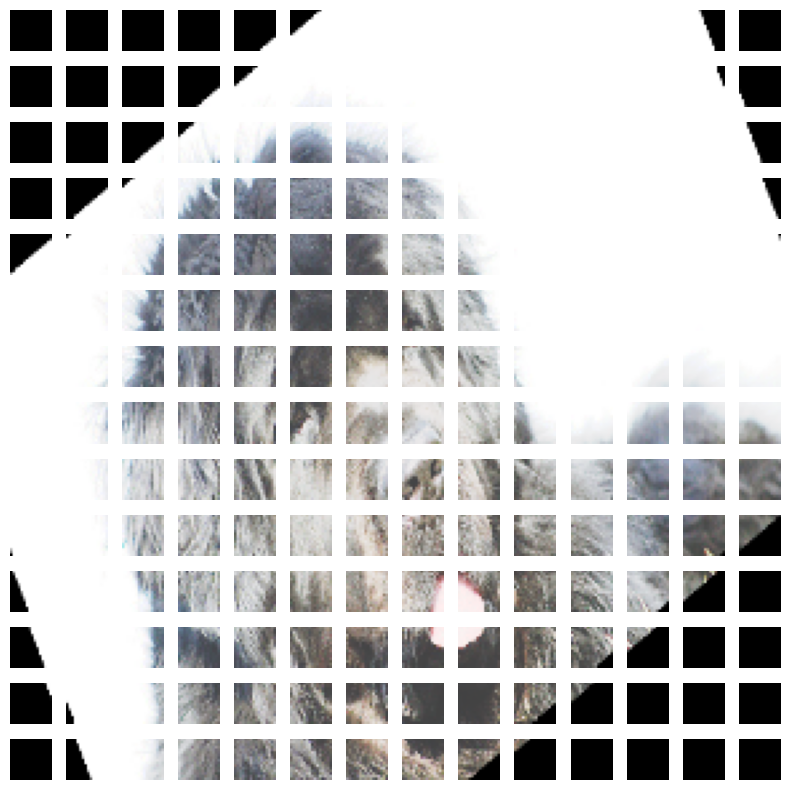

In [64]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(N_PATCHES,N_PATCHES, figsize=(8,8))
patch_list = patchy_pets_train[0][0]
for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.set_axis_off()
        ax.imshow(patch_list[i*N_PATCHES+j].permute(1,2,0).numpy())
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()

In [65]:
import os
from dataclasses import dataclass
import math
from typing import Optional

import torch
from torch import optim, nn, utils, Tensor
from torch.optim.lr_scheduler import LambdaLR
import lightning.pytorch as pl


@dataclass
class ViTConfig:
    d_model: int
    n_heads: int
    n_layers: int
    flat_patch_size: int
    num_classes: int
    dropout_rate: float
    

class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


# class WarmupLinearSchedule(torch.optim.LambdaLR):
#     """ Linear warmup and then linear decay.
#         Linearly increases learning rate from 0 to 1 over `warmup_steps` training steps.
#         Linearly decreases learning rate from 1. to 0. over remaining `t_total - warmup_steps` steps.
#     """
#     def __init__(self, optimizer, warmup_steps, t_total, last_epoch=-1):
#         self.warmup_steps = warmup_steps
#         self.t_total = t_total
#         super(WarmupLinearSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

#     def lr_lambda(self, step):
#         if step < self.warmup_steps:
#             return float(step) / float(max(1, self.warmup_steps))
#         return max(0.0, float(self.t_total - step) / float(max(1.0, self.t_total - self.warmup_steps)))


# define the LightningModule
class LightningViT(pl.LightningModule):
    def __init__(self, config: ViTConfig):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=config.d_model, nhead=config.n_heads, activation='gelu', batch_first=True)
        
        self.classifier_token = nn.Parameter(torch.randn(config.d_model))
        self.patch_projection_layer = nn.Linear(config.flat_patch_size, config.d_model)
        self.positonal_embedding_layer = PositionalEncoding(config.d_model)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=config.n_layers)
        
        self.classification_head = nn.Sequential(nn.Linear(config.d_model, config.d_model), nn.ReLU(), nn.Dropout(config.dropout_rate), nn.Linear(config.d_model, config.num_classes))

    
    def loss_on_batch(self, batch):
        x, y = batch
        # X is batch_size*n_patches*n_channel*patch_height*patch_width. We make a flattened view instead

        batch_size, n_patches, n_channels, height, width = x.shape
        x_flattened = x.reshape(batch_size, n_patches, n_channels*height*width)

        # x_flattened: batch_size*n_patches*n_channels*height_width
        projected_patches = self.patch_projection_layer(x_flattened)
        positional_embedded_patches = self.positonal_embedding_layer(projected_patches)
        
        # Now we add the classifier token. We use our learnable parameter *classifier_token* for this and tile 
        # it *batch_size* number of time so we will be able to concatenate it along the sequence dimension
        tiled_classifier_token = torch.tile(self.classifier_token, (batch_size, 1, 1))
        input_tokens = torch.cat([tiled_classifier_token, positional_embedded_patches], dim=1)

        transformer_representations = self.transformer_encoder(input_tokens)
        classifier_token_state = transformer_representations[:, 0]  # Pick out the memory position corresponding to the classifier token. The sequence dimension is the second one.
        logits = self.classification_head(classifier_token_state)
        
        # Prediction representation now has shape batch_size*num_classes and we can simply compute the loss
        loss = nn.functional.cross_entropy(logits, y)

        return loss
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        loss = self.loss_on_batch(batch)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self.loss_on_batch(batch)
        # Logging to TensorBoard (if installed) by default
        self.log("dev_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss = self.loss_on_batch(batch)
        # Logging to TensorBoard (if installed) by default
        self.log("test_loss", loss)
        return loss
    
    def forward(self, x):
        # X is batch_size*n_patches*n_channel*patch_height*patch_width. We make a flattened view instead

        batch_size, n_patches, n_channels, height, width = x.shape
        x_flattened = x.reshape(batch_size, n_patches, n_channels*height*width)

        # x_flattened: batch_size*n_patches*n_channels*height_width
        projected_patches = self.patch_projection_layer(x_flattened)
        positional_embedded_patches = self.positonal_embedding_layer(projected_patches)
        
        # Now we add the classifier token. We use our learnable parameter *classifier_token* for this and tile 
        # it *batch_size* number of time so we will be able to concatenate it along the sequence dimension
        tiled_classifier_token = torch.tile(self.classifier_token, (batch_size, 1, 1))
        input_tokens = torch.cat([tiled_classifier_token, positional_embedded_patches], dim=1)

        transformer_representations = self.transformer_encoder(input_tokens)
        classifier_token_state = transformer_representations[:, 0]  # Pick out the memory position corresponding to the classifier token. The sequence dimension is the second one.
        logits = self.classification_head(classifier_token_state)
        return logits
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        predictions = torch.argmax(logits, -1)
        return predictions, y
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-4)
        return optimizer


In [66]:
flat_patch_size = 3*PATCH_SIZE**2
config = ViTConfig(d_model=256, n_heads=8, n_layers=4, flat_patch_size=flat_patch_size, num_classes=len(patchy_pets_trainval.classes), dropout_rate=0.1)
model = LightningViT(config)

In [67]:
from pathlib import Path

from lightning import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.lr_monitor import LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

CHECKPOINT_PATH = Path('../models')

trainer = Trainer(default_root_dir = CHECKPOINT_PATH,  # Where to save models
        # We run on a single GPU (if possible)
        accelerator="auto",
        devices=1,
        precision=16,
        accumulate_grad_batches=32, # Effective optimization batch of 1024
        # How many epochs to train for if no patience is set
        max_epochs=50,
        gradient_clip_val=1.,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, mode="min", monitor="dev_loss"
            ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
            LearningRateMonitor("epoch"),
        ],  # Log learning rate every epoch
    )  # In case your notebook crashes due to the progress bar, consider increasing the refresh rate
trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

/home/erik/src/aida-transformers-workshop-code/.venv/lib/python3.10/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=../models/lightning_logs/

In [68]:
from torch.utils.data import DataLoader
batch_size = 32
training_dataloader = DataLoader(patchy_pets_train, batch_size=batch_size, num_workers=4, shuffle=True)
dev_dataloader = DataLoader(patchy_pets_dev, batch_size=batch_size, num_workers=4, shuffle=False)

In [ ]:
trainer.fit(model, training_dataloader, dev_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name                      | Type               | Params | Mode 
-------------------------------------------------------------------------
0 | patch_projection_layer    | Linear             | 196 K  | train
1 | positonal_embedding_layer | PositionalEncoding | 0      | train
2 | transformer_encoder       | TransformerEncoder | 5.3 M  | train
3 | classification_head       | Sequential         | 75.3 K | train
  | other params              | n/a                | 256    | n/a  
-------------------------------------------------------------------------
5.5 M     Trainable params
0         Non-trainable params
5.5 M     Total params
22.131    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode
/home/erik/src/aida-transformers-workshop-code/.venv/lib/python3.10/site-packages/lightning/pytorch/loggers/tensorboard.py:191: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` wa

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

test_dataloader = DataLoader(patchy_pets_test, batch_size=32, drop_last=False, shuffle=False, num_workers=4)

predictions = trainer.predict(dataloaders=dev_dataloader)
predictions, targets = zip(*predictions)
predictions = torch.cat(predictions).cpu().numpy()
targets = torch.cat(targets).cpu().numpy()

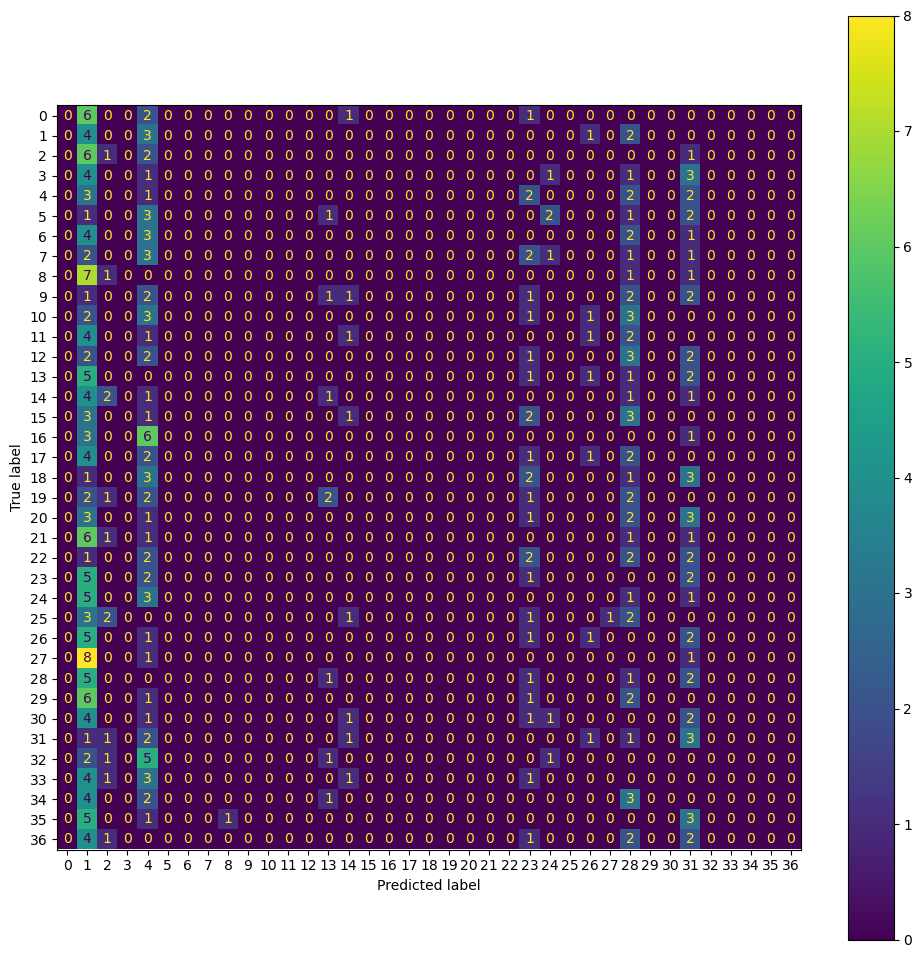

In [ ]:
major_confusion = confusion_matrix(targets, predictions)

fig = plt.figure(figsize=(12,12))
ax = plt.gca()
ConfusionMatrixDisplay(major_confusion).plot(ax=ax)

plt.show()

## Using pretrained models

High performing Transformer models are often large and trained on huge datasets. Fortunately, there are a lot of pre-trained Transformers available. The de-facto Transformer sharing service has become the hugely successful Huggingface Transformers project. While initially focusing on language modelling, it has grown to cover applications in computer vision, audio and multimodal learning, creating a large repository of pretrained Transformer models.

Here will will focus on image classification and how we can use pre-train vision transformers to solve interesting tasks. Huggingface tries to be a framework where you need to know very little about the inner workings of the models, however you will need to adapt your dataset to its mould. Here we will continue using the Oxford Pets dataset to illustrate how you can create your own Huggingface dataset.

### How to create a Huggingface dataset
There are essentially two ways of creating a dataset: use the special `imagefolder` file structure or create your own dataset metadata. In both cases we will use the `load_datasets` function from Huggingfaces `datasets` package.

#### Image folder
```python
from datasets import load_datasets
dataset = load_dataset("imagefolder", data_dir="path/to/folder")
```
Here the special string `"imagefolder"` tells the function that it should scan the `data_dir` after files in a particular way. It will look at common folder in the directory and use those for data splits and class labels:
```shell
folder/train/dog/golden_retriever.png
folder/train/cat/maine_coon.png
folder/test/dog/german_shepherd.png
folder/test/cat/bengal.png
```
The first folder level is the dataset split and the second the dataset classes. 

#### Create your own dataset oacjage

The `"imagefolder"` method is a simple way to get the dataset in place, but if you already have a potentially huge dataset with a certain folder structure in place, you might not wan't to move the files around or create complex symlinks to them. By creating a loading script, naming it the same as your dataset and placing it in your dataset folder root. The `load_dataset` can import that script and generate the necessary file structure:

```
my_dataset/
├── README.md
├── my_dataset.py
└── data/  # optional, may contain your images or TAR archives
```

While this way offers the most flexibility, it's cumbersome to do in a notebook aimed for Google Colab use, so we will use the folder version instead.

In [ ]:
import torchvision
train_dataset = torchvision.datasets.OxfordIIITPet('../datasets/oxfordiiipet', split='trainval', download=True)
test_dataset = torchvision.datasets.OxfordIIITPet('../datasets/oxfordiiipet', split='test', download=True)

In [ ]:
# If we're on a system supporting symlinks, we could create a symlink structure here instead. Here we will copy the data
from pathlib import Path
import shutil

HUGGINGFACE_DATASET_PATH = Path('../datasets/hugginface_oxfordiiipet')
HUGGINGFACE_DATASET_PATH.mkdir(exist_ok=True)

HUGGINGFACE_DATASET_TRAIN_DIR = HUGGINGFACE_DATASET_PATH / 'train'
HUGGINGFACE_DATASET_TEST_DIR = HUGGINGFACE_DATASET_PATH / 'test'

HUGGINGFACE_DATASET_TRAIN_DIR.mkdir(exist_ok=True)
HUGGINGFACE_DATASET_TEST_DIR.mkdir(exist_ok=True)

for train_image, train_label in zip(train_dataset._images, train_dataset._labels):
    string_label = train_dataset.classes[train_label]
    target_dir = HUGGINGFACE_DATASET_TRAIN_DIR / string_label
    target_dir.mkdir(exist_ok=True)
    shutil.copy(train_image, target_dir)

for test_image, test_label in zip(test_dataset._images, test_dataset._labels):
    string_label = test_dataset.classes[test_label]
    target_dir = HUGGINGFACE_DATASET_TEST_DIR / string_label
    target_dir.mkdir(exist_ok=True)
    shutil.copy(test_image, target_dir)

In [ ]:
from datasets import load_dataset
hugging_pets = load_dataset(str(HUGGINGFACE_DATASET_PATH))
hugging_pets

Resolving data files:   0%|          | 0/7360 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/7338 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7360
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 7338
    })
})

In [ ]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [ ]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [ ]:
import torch
import torchvision
from torchvision.transforms import v2
from torchvision.transforms.v2 import Transform, Normalize

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = v2.Compose([
    v2.ToImageTensor(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.uint8),  # optional, most input are already uint8 at this point
    v2.AutoAugment(),
    v2.RandomResizedCrop(size),
    v2.ConvertDtype(),
    normalize
])

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

hugging_pets = hugging_pets.with_transform(transforms)


In [ ]:
labels = hugging_pets["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label
label2id

{'Abyssinian': '0',
 'American Bulldog': '1',
 'American Pit Bull Terrier': '2',
 'Basset Hound': '3',
 'Beagle': '4',
 'Bengal': '5',
 'Birman': '6',
 'Bombay': '7',
 'Boxer': '8',
 'British Shorthair': '9',
 'Chihuahua': '10',
 'Egyptian Mau': '11',
 'English Cocker Spaniel': '12',
 'English Setter': '13',
 'German Shorthaired': '14',
 'Great Pyrenees': '15',
 'Havanese': '16',
 'Japanese Chin': '17',
 'Keeshond': '18',
 'Leonberger': '19',
 'Maine Coon': '20',
 'Miniature Pinscher': '21',
 'Newfoundland': '22',
 'Persian': '23',
 'Pomeranian': '24',
 'Pug': '25',
 'Ragdoll': '26',
 'Russian Blue': '27',
 'Saint Bernard': '28',
 'Samoyed': '29',
 'Scottish Terrier': '30',
 'Shiba Inu': '31',
 'Siamese': '32',
 'Sphynx': '33',
 'Staffordshire Bull Terrier': '34',
 'Wheaten Terrier': '35',
 'Yorkshire Terrier': '36'}

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=hugging_pets["train"],
    eval_dataset=hugging_pets["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/home/erik/mambaforge/envs/aida_workshop_transformer/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,2.677100,2.596785,0.745298
2,2.047900,2.082068,0.773508
3,1.894200,1.938471,0.783592


/home/erik/mambaforge/envs/aida_workshop_transformer/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/erik/mambaforge/envs/aida_workshop_transformer/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(),

TrainOutput(global_step=345, training_loss=2.4397569131160126, metrics={'train_runtime': 448.2633, 'train_samples_per_second': 49.257, 'train_steps_per_second': 0.77, 'total_flos': 1.711559868259369e+18, 'train_loss': 2.4397569131160126, 'epoch': 3.0})

## Prediction

In [ ]:
image = hugging_pets["train"]["image"][0]

In [ ]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("my_awesome_food_model")
inputs = image_processor(image, return_tensors="pt")

In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("my_awesome_food_model")
with torch.no_grad():
    logits = model(**inputs).logits

In [ ]:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]